# Phase 1: Data Preparation - KITTI Subset

**Install Required Packages**

In [1]:
!pip install -q ultralytics tqdm opencv-python-headless matplotlib pyyaml

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 25.2 MB/s eta 0:00:00


**Create Project Folder Structure**

In [2]:
from pathlib import Path

PROJECT_ROOT = Path('./kitti_phase1')
EXTRACT_DIR = PROJECT_ROOT / 'kitti_extracted'
YOLO_DIR = PROJECT_ROOT / 'kitti_yolo'

for d in [EXTRACT_DIR, YOLO_DIR]:
    d.mkdir(parents=True, exist_ok=True)

(YOLO_IMAGES_TRAIN := YOLO_DIR / 'images' / 'train').mkdir(parents=True, exist_ok=True)
(YOLO_LABELS_TRAIN := YOLO_DIR / 'labels' / 'train').mkdir(parents=True, exist_ok=True)
(YOLO_IMAGES_VAL := YOLO_DIR / 'images' / 'val').mkdir(parents=True, exist_ok=True)
(YOLO_LABELS_VAL := YOLO_DIR / 'labels' / 'val').mkdir(parents=True, exist_ok=True)

PROJECT_ROOT, EXTRACT_DIR, YOLO_DIR

(PosixPath('kitti_phase1'),
 PosixPath('kitti_phase1/kitti_extracted'),
 PosixPath('kitti_phase1/kitti_yolo'))

**Upload the KITTI Subset ZIP**

In [3]:
from google.colab import files
import zipfile

print("Upload kitti_subset.zip file now")
uploaded = files.upload()

zip_name = next(iter(uploaded.keys()))
with zipfile.ZipFile(zip_name, 'r') as z:
    z.extractall(EXTRACT_DIR)

IMAGES_DIR = EXTRACT_DIR / 'kitti_subset' / 'training' / 'image_2'
LABELS_DIR = EXTRACT_DIR / 'kitti_subset' / 'training' / 'label_2'

print("Images folder:", IMAGES_DIR)
print("Labels folder:", LABELS_DIR)
print("Number of images:", len(list(IMAGES_DIR.glob('*.png'))))
print("Number of labels:", len(list(LABELS_DIR.glob('*.txt'))))

Upload kitti_subset.zip file now


Saving kitti_subset.zip to kitti_subset (1).zip
Images folder: kitti_phase1/kitti_extracted/kitti_subset/training/image_2
Labels folder: kitti_phase1/kitti_extracted/kitti_subset/training/label_2
Number of images: 100
Number of labels: 100


**Define Image and Label Directories, Preview a Sample Image, and Preview the Matching Label File**

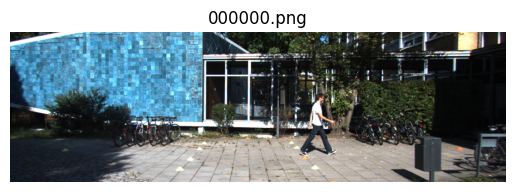

Label file: 000000.txt
Pedestrian 0.00 0 -0.20 712.40 143.00 810.73 307.92 1.89 0.48 1.20 1.84 1.47 8.41 0.01


In [4]:
import cv2, matplotlib.pyplot as plt

sample_img_path = sorted(IMAGES_DIR.glob('*.png'))[0]
img = cv2.cvtColor(cv2.imread(str(sample_img_path)), cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.axis('off')
plt.title(sample_img_path.name)
plt.show()

sample_lbl_path = LABELS_DIR / (sample_img_path.stem + '.txt')
print("Label file:", sample_lbl_path.name)
print("\n".join(open(sample_lbl_path).read().splitlines()[:10]))

**Check for Missing or Empty Labels**

In [5]:
from tqdm import tqdm

images = sorted(IMAGES_DIR.glob('*.png'))
labels = sorted(LABELS_DIR.glob('*.txt'))
img_set = {p.stem for p in images}
lbl_set = {p.stem for p in labels}

imgs_without_lbl = [p for p in images if p.stem not in lbl_set]
lbl_without_imgs = [p for p in labels if p.stem not in img_set]
empty_label_files = [p for p in labels if p.stat().st_size == 0]

print("Images without label:", len(imgs_without_lbl))
print("Labels without image:", len(lbl_without_imgs))
print("Empty label files:", len(empty_label_files))

Images without label: 0
Labels without image: 0
Empty label files: 0


**Remove Missing/Empty Label Files**

In [11]:
valid_labels = {p.stem for p in labels if p.stat().st_size > 0}
images = [p for p in images if p.stem in valid_labels]  # keep images with non-empty label
print("Usable images after removing missing/empty labels:", len(images))

CLEAN_REPORT = {
    "imgs_without_lbl": [p.name for p in imgs_without_lbl],
    "lbl_without_imgs": [p.name for p in lbl_without_imgs],
    "empty_label_files": [p.name for p in empty_label_files],
}

Usable images after removing missing/empty labels: 100


**Remove Duplicate Images**

In [12]:
import hashlib

def file_md5(path, chunk=8192):
    h = hashlib.md5()
    with open(path, "rb") as f:
        while True:
            data = f.read(chunk)
            if not data: break
            h.update(data)
    return h.hexdigest()

hash_seen = set()
unique_images = []
dupe_images = []
for p in images:
    h = file_md5(p)
    if h in hash_seen:
        dupe_images.append(p)
    else:
        hash_seen.add(h)
        unique_images.append(p)

images = unique_images
print("Removed duplicate images:", len(dupe_images))
CLEAN_REPORT["duplicate_images"] = [p.name for p in dupe_images]

Removed duplicate images: 0


**Visualize Bounding Boxes on a Sample Image**

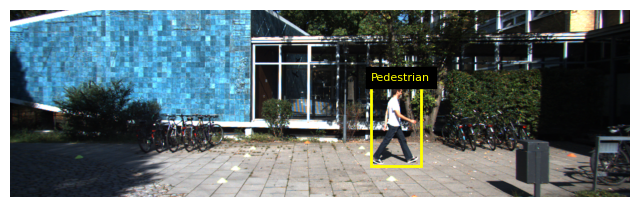

In [6]:
import matplotlib.patches as patches

def read_kitti_objects(lbl_path):
    objs = []
    for line in open(lbl_path).read().splitlines():
        parts = line.split()
        if len(parts) < 8:
            continue
        cls = parts[0]
        try:
            x1, y1, x2, y2 = map(float, parts[4:8])
            objs.append({'cls': cls, 'bbox': [x1, y1, x2, y2]})
        except:
            continue
    return objs

fig, ax = plt.subplots(figsize=(8,5))
ax.imshow(img)
ax.axis('off')

objs = read_kitti_objects(sample_lbl_path)
for o in objs[:10]:
    x1, y1, x2, y2 = o['bbox']
    rect = patches.Rectangle((x1,y1), x2-x1, y2-y1, linewidth=2, edgecolor='yellow', facecolor='none')
    ax.add_patch(rect)
    ax.text(x1, y1-3, o['cls'], fontsize=8, color='yellow', backgroundcolor='black')
plt.show()

**Define Classes and Label Conversion Functions**

In [13]:
CLASSES = ['Car', 'Pedestrian', 'Cyclist']
CLASS_TO_ID = {c:i for i,c in enumerate(CLASSES)}

def kitti_to_yolo_bbox(x1, y1, x2, y2, W, H):
    x_center = ((x1 + x2) / 2.0) / W
    y_center = ((y1 + y2) / 2.0) / H
    w = (x2 - x1) / W
    h = (y2 - y1) / H
    return x_center, y_center, w, h

**Convert KITTI Labels to YOLO Format with Outlier Filtering**

In [ ]:
def convert_file_to_yolo(img_path, lbl_path):
    import cv2, math
    H, W = cv2.imread(str(img_path)).shape[:2]
    lines_out = []
    min_area_frac = 1e-5      # drop boxes smaller than this fraction of image area
    max_area_frac = 0.8       # drop boxes that cover almost whole image
    max_aspect = 20.0         # drop boxes with extreme aspect ratio

    for line in open(lbl_path).read().splitlines():
        parts = line.split()
        if len(parts) < 8:
            continue
        cls = parts[0]
        if cls not in CLASS_TO_ID:
            continue

        x1, y1, x2, y2 = map(float, parts[4:8])
        # clamp to image bounds
        x1, y1 = max(0.0, x1), max(0.0, y1)
        x2, y2 = min(float(W-1), x2), min(float(H-1), y2)
        if x2 <= x1 or y2 <= y1:
            continue

        # outlier checks
        bw, bh = (x2 - x1), (y2 - y1)
        area_frac = (bw * bh) / float(W * H)
        aspect = max(bw / max(bh,1e-6), bh / max(bw,1e-6))
        if area_frac < min_area_frac or area_frac > max_area_frac or aspect > max_aspect:
            continue

        xc = ((x1 + x2) / 2.0) / W
        yc = ((y1 + y2) / 2.0) / H
        w  = bw / W
        h  = bh / H
        if w <= 0 or h <= 0:
            continue

        lines_out.append(f"{CLASS_TO_ID[cls]} {xc:.6f} {yc:.6f} {w:.6f} {h:.6f}")
    return lines_out

**Split Dataset into Train (80%) and Validation (20%)**

In [8]:
import random, shutil

random.seed(42)
usable_images = [p for p in images if (LABELS_DIR / (p.stem + '.txt')).exists()]
random.shuffle(usable_images)

split_idx = int(0.8 * len(usable_images))
train_imgs = usable_images[:split_idx]
val_imgs = usable_images[split_idx:]

def process_split(img_paths, images_out_dir, labels_out_dir):
    images_out_dir.mkdir(parents=True, exist_ok=True)
    labels_out_dir.mkdir(parents=True, exist_ok=True)
    kept, skipped = 0, 0
    for ip in tqdm(img_paths):
        lp = LABELS_DIR / (ip.stem + '.txt')
        lines = convert_file_to_yolo(ip, lp)
        if len(lines) == 0:
            skipped += 1
            continue
        shutil.copy2(ip, images_out_dir / ip.name)
        with open(labels_out_dir / (ip.stem + '.txt'), 'w') as f:
            f.write('\n'.join(lines) + '\n')
        kept += 1
    return kept, skipped

kept_tr, skip_tr = process_split(train_imgs, YOLO_IMAGES_TRAIN, YOLO_LABELS_TRAIN)
kept_va, skip_va = process_split(val_imgs, YOLO_IMAGES_VAL, YOLO_LABELS_VAL)

print({'train_kept': kept_tr, 'train_skipped': skip_tr, 'val_kept': kept_va, 'val_skipped': skip_va})

100%|██████████| 20/20 [00:01<00:00, 17.52it/s]

{'train_kept': 80, 'train_skipped': 0, 'val_kept': 20, 'val_skipped': 0}


**Write YOLO Data Configuration (data.yaml)**

In [9]:
import yaml

data_yaml = {
    'path': str(YOLO_DIR.resolve()),
    'train': 'images/train',
    'val': 'images/val',
    'names': CLASSES,
}
with open(YOLO_DIR / 'data.yaml', 'w') as f:
    yaml.safe_dump(data_yaml, f, sort_keys=False)
print((YOLO_DIR / 'data.yaml').read_text())

path: /content/kitti_phase1/kitti_yolo
train: images/train
val: images/val
names:
- Car
- Pedestrian
- Cyclist



**Count Train/Val Images and Labels and Package Final YOLO Dataset as ZIP**

In [10]:
n_tr_img = len(list((YOLO_IMAGES_TRAIN).glob('*.png')))
n_tr_lbl = len(list((YOLO_LABELS_TRAIN).glob('*.txt')))
n_va_img = len(list((YOLO_IMAGES_VAL).glob('*.png')))
n_va_lbl = len(list((YOLO_LABELS_VAL).glob('*.txt')))

print('Train images:', n_tr_img, '| Train labels:', n_tr_lbl)
print('Val images  :', n_va_img, '| Val labels  :', n_va_lbl)

import shutil
zip_path = PROJECT_ROOT / 'kitti_yolo_prepared.zip'
if zip_path.exists(): zip_path.unlink()
shutil.make_archive(str(zip_path.with_suffix('')), 'zip', root_dir=YOLO_DIR)

from google.colab import files
files.download(str(zip_path))

Train images: 80 | Train labels: 80
Val images  : 20 | Val labels  : 20


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Save Cleaning Report as JSON**

In [14]:
import json
CLEAN_REPORT.update({
    "train_kept": kept_tr, "train_skipped": skip_tr,
    "val_kept": kept_va,   "val_skipped": skip_va
})
with open(PROJECT_ROOT / "cleaning_report.json", "w") as f:
    json.dump(CLEAN_REPORT, f, indent=2)
print("Saved cleaning_report.json")

Saved cleaning_report.json
